In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import plotly.graph_objs as go
%matplotlib inline
from random import sample
import seaborn as sns
import datetime as dt
from pandas_datareader import data as pdr
from dataclasses import dataclass

In [2]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [3]:
def weekly_data(index):
    index_ffill = index.resample('d').asfreq().ffill() 
    index_fri = index_ffill[index_ffill.index.dayofweek==4]
    return index_fri

In [4]:
def EWMA(df, n):
    EWMA = pd.Series(df["Adj Close"].ewm(span=n).mean(),name = "EWMA_" + str(n))
    return EWMA

def EWMV(df, n):
    EWMV = pd.Series(df.ewm(span=n).mean(),name = "EWMV_" + str(n))
    return EWMV

def ATR(df,n):
    ATR = pd.concat([(df['High']-df['Low']),
           np.abs(df['High'] - df['Adj Close'].shift(1)),
           np.abs(df['Low']-df['Adj Close'].shift(1))],axis=1).max(axis=1).rolling(n).mean()
    return ATR

def DIV(df,N):
    alpha = 1.34
    k =(alpha-1)/(alpha+(N+1)/(N-1))
    c = np.log(df['Adj Close']/df['Open'])
    u = np.log(df['Adj Close']/df['Open'])
    o = np.log(df['Open']/df['Adj Close'].shift(1))
    d = np.log(df['Low']/df['Open'])
    V0 = ((o-o.rolling(N).mean())**2).rolling(N).sum()/(N-1)
    Vc = ((c-c.rolling(N).mean())**2).rolling(N).sum()/(N-1)
    Vrs = (u*(u-c)+d*(d-c)).rolling(N).mean()
    DIV = V0 + k*Vc +(1-k)*Vrs
    return DIV

In [5]:
def g_mean_f1(y_true,y_pred):
    c_m = confusion_matrix(y_true,y_pred)
    p_precision = c_m[0,0] / (c_m[0,0] + c_m[0,1])
    p_recall = c_m[0,0] / (c_m[0,0] + c_m[1,0])
    n_precision = c_m[1,1] / (c_m[1,1] + c_m[1,0])
    n_recall = c_m[1,1] / (c_m[1,1] + c_m[0,1])
    p_f1_score = 2*(p_precision * p_recall)/(p_precision+p_recall)
    n_f1_score = 2*(n_precision * n_recall)/(n_precision+n_recall)
    return (p_f1_score * n_f1_score)**0.5

### Load Data

In [6]:
pd.read_csv('indiavix.csv',index_col=[0])[::-1]

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
03/04/2008,38.0800,38.0800,51.0700,30.5900,NaN,6.49%
03/05/2008,35.5100,38.0800,38.7600,27.9500,NaN,-6.75%
03/07/2008,35.2000,36.9500,39.3400,27.0500,NaN,-0.87%
03/10/2008,32.5800,25.3300,47.9500,25.3300,NaN,-7.44%
03/11/2008,32.6900,30.7200,37.5400,29.7500,NaN,0.34%
...,...,...,...,...,...,...
11/23/2022,14.2000,11.8750,14.3275,11.8750,NaN,2.38%
11/24/2022,13.5400,13.4700,13.8700,13.1075,NaN,-4.65%
11/25/2022,13.3275,13.0425,14.1500,12.7775,NaN,-1.57%


In [7]:
india_vix = pd.read_csv('indiavix.csv',index_col=[0])[::-1]
india_vix.index = pd.to_datetime(india_vix.index)
india_vix.rename(columns={'Price':'Adj Close'},inplace=True)
india_vix_w = weekly_data(india_vix)
india_vix_w

,Adj Close,Open,High,Low,Vol.,Change %
Date,,,,,,
2008-03-07,35.2000,36.9500,39.3400,27.0500,NaN,-0.87%
2008-03-14,31.1100,36.3200,37.8200,29.0700,NaN,-8.90%
2008-03-21,35.4900,37.8400,41.8400,30.0400,NaN,-6.21%
2008-03-28,33.0700,46.1500,46.1500,28.4300,NaN,-11.29%
2008-04-04,36.9300,36.6800,37.2300,30.3300,NaN,0.68%
...,...,...,...,...,...,...
2022-10-28,15.9225,16.5975,17.0375,15.8475,NaN,-4.07%
2022-11-04,15.6550,15.9425,16.2075,15.4825,NaN,-1.80%
2022-11-11,14.4050,15.5675,15.5675,14.2775,NaN,-7.47%


In [8]:
india_vix_w['vix_return'] = np.log(india_vix_w['Adj Close']/india_vix_w['Adj Close'].shift(1)).fillna(0)
india_vix_w['EWMA_1'] = EWMA(india_vix_w,1)
india_vix_w['EWMA_2'] = EWMA(india_vix_w,2)
india_vix_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 769 entries, 2008-03-07 to 2022-11-25
Freq: 7D
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Adj Close   769 non-null    float64
 1   Open        769 non-null    float64
 2   High        769 non-null    float64
 3   Low         769 non-null    float64
 4   Vol.        0 non-null      float64
 5   Change %    769 non-null    object 
 6   vix_return  769 non-null    float64
 7   EWMA_1      769 non-null    float64
 8   EWMA_2      769 non-null    float64
dtypes: float64(8), object(1)
memory usage: 60.1+ KB


In [9]:
india_vix_w.to_csv('india_vix.to_csv')

In [10]:
start = dt.date(2008, 3,4)
end = dt.date(2022, 11, 29)
nifty50=pdr.get_data_yahoo('^NSEI',start=start,end=end)
nifty50.index = pd.to_datetime(nifty50.index)
nifty50_w = weekly_data(nifty50)
nifty50_w

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-03-07,4918.299805,4672.250000,4918.299805,4771.600098,0.0,4771.600098
2008-03-14,4758.950195,4607.549805,4623.799805,4745.799805,0.0,4745.799805
2008-03-21,4718.399902,4533.899902,4534.750000,4573.950195,0.0,4573.950195
2008-03-28,4970.799805,4796.350098,4830.000000,4942.000000,0.0,4942.000000
2008-04-04,4791.700195,4632.700195,4766.700195,4647.000000,0.0,4647.000000
...,...,...,...,...,...,...
2022-10-28,17838.900391,17723.699219,17756.400391,17786.800781,250000.0,17786.800781
2022-11-04,18135.099609,18017.150391,18053.400391,18117.150391,267900.0,18117.150391
2022-11-11,18362.300781,18259.349609,18272.349609,18349.699219,378500.0,18349.699219


In [11]:
nifty50_w['nifty_return'] = np.log(nifty50_w['Adj Close']/nifty50_w['Adj Close'].shift(1)).fillna(0)
nifty50_w['EWMV_2'] = EWMV(nifty50_w['nifty_return'],2)
nifty50_w['ATR_2'] = ATR(nifty50_w,2)
nifty50_w['ATR_4'] = ATR(nifty50_w,4)
nifty50_w['DIV_2'] = DIV(nifty50_w,2)
nifty50_w['DIV_4'] = DIV(nifty50_w,4)
nifty50_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 769 entries, 2008-03-07 to 2022-11-25
Freq: 7D
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   High          769 non-null    float64
 1   Low           769 non-null    float64
 2   Open          769 non-null    float64
 3   Close         769 non-null    float64
 4   Volume        769 non-null    float64
 5   Adj Close     769 non-null    float64
 6   nifty_return  769 non-null    float64
 7   EWMV_2        769 non-null    float64
 8   ATR_2         768 non-null    float64
 9   ATR_4         766 non-null    float64
 10  DIV_2         766 non-null    float64
 11  DIV_4         762 non-null    float64
dtypes: float64(12)
memory usage: 78.1 KB


In [12]:
start = dt.date(2008, 3,4)
end = dt.date(2022, 11, 29)
inr = pdr.get_data_yahoo('INR=X',start=start,end=end)
inr_w = weekly_data(inr)
inr_w['inr_return'] = np.log(inr_w['Adj Close']/inr_w['Adj Close'].shift(1)).fillna(0)
inr_w

,High,Low,Open,Close,Volume,Adj Close,inr_return
Date,,,,,,,
2008-03-07,40.630001,40.064999,40.064999,40.238998,0.0,40.238998,0.000000
2008-03-14,40.549999,39.869999,40.365002,40.075001,0.0,40.075001,-0.004084
2008-03-21,40.185001,40.185001,40.185001,40.185001,0.0,40.185001,0.002741
2008-03-28,40.119999,39.615002,39.985001,39.615002,0.0,39.615002,-0.014286
2008-04-04,40.029999,39.761002,39.875000,39.805000,0.0,39.805000,0.004785
...,...,...,...,...,...,...,...
2022-10-28,82.781303,82.278000,82.442497,82.442497,0.0,82.442497,-0.004637
2022-11-04,82.991798,82.002098,82.681801,82.681801,0.0,82.681801,0.002898
2022-11-11,80.983002,80.423798,80.482903,80.482903,0.0,80.482903,-0.026955


In [13]:
start = dt.date(2008, 3,4)
end = dt.date(2022, 11, 29)
sp500=pdr.get_data_yahoo('^GSPC',start=start,end=end)
sp500_w = weekly_data(sp500)
sp500_w['sp500_return'] = np.log(sp500_w['Adj Close']/sp500_w['Adj Close'].shift(1)).fillna(0)
sp500_w

,High,Low,Open,Close,Volume,Adj Close,sp500_return
Date,,,,,,,
2008-03-07,1313.239990,1282.430054,1301.530029,1293.369995,4.565410e+09,1293.369995,0.000000
2008-03-14,1321.469971,1274.859985,1316.050049,1288.140015,5.153780e+09,1288.140015,-0.004052
2008-03-21,1330.670044,1295.219971,1299.670044,1329.510010,6.145220e+09,1329.510010,0.031611
2008-03-28,1334.869995,1312.949951,1327.020020,1315.219971,3.686980e+09,1315.219971,-0.010807
2008-04-04,1380.910034,1362.829956,1369.849976,1370.400024,3.703100e+09,1370.400024,0.041099
...,...,...,...,...,...,...,...
2022-10-28,3905.419922,3808.260010,3808.260010,3901.060059,4.459410e+09,3901.060059,0.038759
2022-11-04,3796.340088,3708.840088,3766.979980,3770.550049,5.400180e+09,3770.550049,-0.034027
2022-11-11,4001.479980,3944.820068,3963.719971,3992.929932,5.593310e+09,3992.929932,0.057304


In [14]:
start = dt.date(2008, 3,4)
end = dt.date(2022, 11, 29)
vix=pdr.get_data_yahoo('^VIX',start=start,end=end)
vix_w = weekly_data(vix)
vix_w['us_vix_return'] = np.log(vix_w['Adj Close']/vix_w['Adj Close'].shift(1)).fillna(0)
vix_w

,High,Low,Open,Close,Volume,Adj Close,us_vix_return
Date,,,,,,,
2008-03-07,29.290001,22.290001,28.520000,27.490000,0.0,27.490000,0.000000
2008-03-14,32.889999,26.020000,27.309999,31.160000,0.0,31.160000,0.125313
2008-03-21,29.840000,25.799999,29.840000,26.620001,0.0,26.620001,-0.157472
2008-03-28,25.959999,25.040001,25.809999,25.709999,0.0,25.709999,-0.034783
2008-04-04,23.309999,21.750000,23.000000,22.450001,0.0,22.450001,-0.135589
...,...,...,...,...,...,...,...
2022-10-28,27.590000,25.750000,27.430000,25.750000,0.0,25.750000,-0.142376
2022-11-04,25.709999,24.000000,25.629999,24.549999,0.0,24.549999,-0.047723
2022-11-11,23.910000,22.370001,23.889999,22.520000,0.0,22.520000,-0.086308


In [15]:
bond = pd.read_csv('bond.csv',index_col=[0])
bond.index = pd.to_datetime(bond.index)
bond_w = weekly_data(bond)
india_bond = bond_w.iloc[:,-1]
india_bond.name = 'GTINR2YR Corp'

### Variables

In [99]:
Y = np.sign(np.log(india_vix_w['Adj Close']/india_vix_w['Adj Close'].shift(1))).shift(-1).dropna()
Y = Y.apply(lambda x:np.where(x==0,-1,x))
Y.name = 'vix'

data =pd.concat([Y,
                 india_vix_w[['Adj Close','High','Low','vix_return']],
                 nifty50_w[['nifty_return','EWMV_2','ATR_2','ATR_4','DIV_2','DIV_4']],
                 inr_w[['inr_return']],
                 vix_w[['us_vix_return']],
                 sp500_w['sp500_return'],
                 india_bond
                ],
                axis=1)
data = data['2008-03-07':]
data

,vix,Adj Close,High,Low,vix_return,nifty_return,EWMV_2,ATR_2,ATR_4,DIV_2,DIV_4,inr_return,us_vix_return,sp500_return,GTINR2YR Corp
2008-03-07,-1.0,35.2000,39.3400,27.0500,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,7.540
2008-03-14,1.0,31.1100,37.8200,29.0700,-0.123517,-0.005422,-0.004066,205.050049,NaN,NaN,NaN,-0.004084,0.125313,-0.004052,7.527
2008-03-21,-1.0,35.4900,41.8400,30.0400,0.131722,-0.036883,-0.026785,187.975098,NaN,NaN,NaN,0.002741,-0.157472,0.031611,7.500
2008-03-28,1.0,33.0700,46.1500,28.4300,-0.070624,0.077393,0.043535,304.374756,254.712402,0.002654,NaN,-0.014286,-0.034783,-0.010807,7.495
2008-04-04,-1.0,36.9300,37.2300,30.3300,0.110398,-0.061548,-0.026810,353.074707,270.524902,0.004736,NaN,0.004785,-0.135589,0.041099,7.667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-28,-1.0,15.9225,17.0375,15.8475,-0.081817,0.011905,0.012539,373.525391,292.212891,0.000220,0.000293,-0.004637,-0.142376,0.038759,7.006
2022-11-04,-1.0,15.6550,16.2075,15.4825,-0.016943,0.018402,0.016448,305.449219,318.537598,0.000070,0.000210,0.002898,-0.047723,-0.034027,7.167
2022-11-11,-1.0,14.4050,15.5675,14.2775,-0.083215,0.012754,0.013985,296.724609,335.125000,0.000022,0.000213,-0.026955,-0.086308,0.057304,6.963
2022-11-18,-1.0,14.3900,15.6925,13.8600,-0.001042,-0.002294,0.003132,214.974609,260.211914,0.000048,0.000050,0.012864,0.026294,-0.006934,6.901


In [17]:
Y = data.iloc[:,0]
X = data.iloc[:,1:].ffill().bfill()

In [100]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 769 entries, 2008-03-07 to 2022-11-25
Freq: 7D
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Adj Close      769 non-null    float64
 1   High           769 non-null    float64
 2   Low            769 non-null    float64
 3   vix_return     769 non-null    float64
 4   nifty_return   769 non-null    float64
 5   EWMV_2         769 non-null    float64
 6   ATR_2          769 non-null    float64
 7   ATR_4          769 non-null    float64
 8   DIV_2          769 non-null    float64
 9   DIV_4          769 non-null    float64
 10  inr_return     769 non-null    float64
 11  us_vix_return  769 non-null    float64
 12  sp500_return   769 non-null    float64
 13  GTINR2YR Corp  769 non-null    float64
dtypes: float64(14)
memory usage: 106.3 KB


<AxesSubplot: >

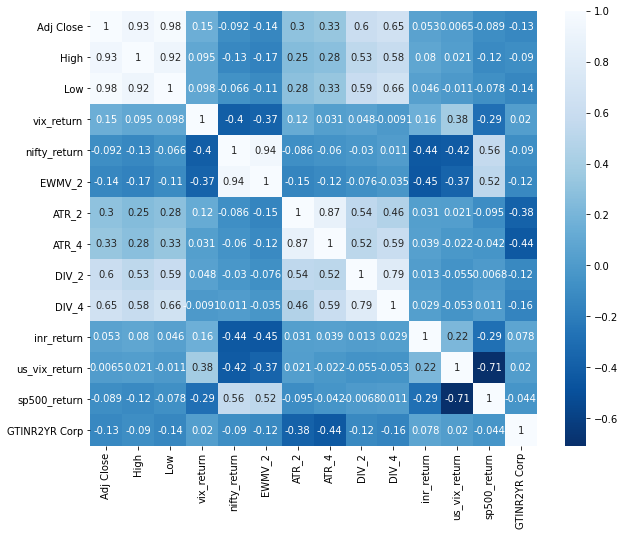

In [88]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(),annot=True,cmap='Blues_r')

In [18]:
scaler = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X),index = X.index,columns=X.columns)
scaled_X

,Adj Close,High,Low,vix_return,nifty_return,EWMV_2,ATR_2,ATR_4,DIV_2,DIV_4,inr_return,us_vix_return,sp500_return,GTINR2YR Corp
2008-03-07,1.534192,1.388811,0.889990,0.011502,-0.062845,-0.086655,-0.073898,0.281941,1.297207,-0.251327,-0.087853,0.002476,-0.055646,0.562562
2008-03-14,1.092762,1.261917,1.122830,-1.113373,-0.256106,-0.287289,-0.073898,0.281941,1.297207,-0.251327,-0.477730,0.815843,-0.208334,0.552804
2008-03-21,1.565491,1.597519,1.234639,1.211099,-1.377559,-1.408267,-0.183817,0.281941,1.297207,-0.251327,0.173831,-1.019628,1.135569,0.532536
2008-03-28,1.304303,1.957331,1.049059,-0.631679,2.695884,2.061395,0.565495,0.281941,1.297207,-0.251327,-1.451683,-0.223288,-0.462872,0.528783
2008-04-04,1.720909,1.212662,1.268066,1.016900,-2.256780,-1.409482,0.878997,0.399308,2.725055,-0.251327,0.368922,-0.877592,1.493095,0.657895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-28,-0.546409,-0.473071,-0.401290,-0.733606,0.361525,0.532031,1.010646,0.560286,-0.372132,-0.334646,-0.530564,-0.921640,1.404941,0.161715
2022-11-04,-0.575280,-0.542362,-0.443362,-0.142798,0.593122,0.724899,0.572412,0.755679,-0.475413,-0.395581,0.188854,-0.307277,-1.337915,0.282570
2022-11-11,-0.710192,-0.595792,-0.582259,-0.746342,0.391787,0.603397,0.516248,0.878797,-0.507904,-0.392963,-2.661129,-0.557722,2.103779,0.129437
2022-11-18,-0.711811,-0.585356,-0.630383,0.002014,-0.144622,0.067899,-0.010010,0.322761,-0.490521,-0.511308,1.140205,0.173144,-0.316929,0.082897


In [19]:
# train and test
split_date_1 = dt.datetime(2019,11,29)
split_date_2 = dt.datetime(2019,12,6)
X_train, X_test = scaled_X.loc[:split_date_1,:], scaled_X.loc[split_date_2:,:]
Y_train, Y_test = Y[:split_date_1], Y[split_date_2:]
# train and validation
split_date_1 = dt.datetime(2016,12,23)
split_date_2 = dt.datetime(2016,12,30)
X_train_v, X_validation = X_train.loc[:split_date_1,:], X_train.loc[split_date_2:,:]
Y_train_v, Y_validation = Y_train.loc[:split_date_1], Y_train.loc[split_date_2:]

In [20]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [21]:
names = []
is_accuracy = []
os_accuracy = []
is_gmeanf1 = []
os_gmeanf1 = []

### Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier 

In [27]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = { 'min_samples_split': [2, 3, 4, 5], 'max_depth': np.arange(3,14),
#                  'min_samples_leaf': [1,2,3,4,5]}
# model = DecisionTreeClassifier(class_weight='balanced')
# optimized_DT = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_DT.fit(np.array(X_train_v), np.array(Y_train_v))
# model = optimized_DT.best_estimator_
# print('Best parameters：{0}'.format(optimized_DT.best_params_))
# print('Score:{0}'.format(optimized_DT.best_score_))

Best parameters：{'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 3}
Score:0.5228758169934641


In [28]:
DT = DecisionTreeClassifier(max_depth=11,min_samples_leaf=3,min_samples_split= 3).fit(X_train_v, Y_train_v)

In [29]:
y_pred_DT_is = DT.predict(X_train_v)
y_pred_DT_os = DT.predict(X_validation)
accuracy_DT_is = metrics.accuracy_score(Y_train_v, y_pred_DT_is)
accuracy_DT_os = metrics.accuracy_score(Y_validation, y_pred_DT_os)
print("DT accuarcy in sample:",accuracy_DT_is)
print("DT accuarcy out sample:",accuracy_DT_os)

DT accuarcy in sample: 0.8695652173913043
DT accuarcy out sample: 0.5228758169934641


In [30]:
g_mean_f1_DT_is = g_mean_f1(Y_train_v, y_pred_DT_is)
g_mean_f1_DT_os = g_mean_f1(Y_validation, y_pred_DT_os)
print("DT gmean f1 in sample:",g_mean_f1_DT_is)
print("DT gmean f1 out sample:",g_mean_f1_DT_os)

DT gmean f1 in sample: 0.8692996135866036
DT gmean f1 out sample: 0.4627995399559232


In [31]:
names.append('DT')
is_accuracy.append(accuracy_DT_is)
os_accuracy.append(accuracy_DT_os)
is_gmeanf1.append(g_mean_f1_DT_is)
os_gmeanf1.append(g_mean_f1_DT_os)

### Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = { 'n_estimators':[25,50,100,200],'min_samples_split': [2, 3, 4], 'max_depth': np.arange(3,13),
#                  'min_samples_leaf': [1,2,3],'max_features':["auto", "sqrt", "log2"]}
# model = RandomForestClassifier()
# optimized_RF = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_RF.fit(np.array(X_train_v), np.array(Y_train_v))
# print('Best parameters：{0}'.format(optimized_RF.best_params_))
# print('Score:{0}'.format(optimized_RF.best_score_))

Best parameters：{'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Score:0.5784313725490196


In [33]:
RF= RandomForestClassifier(n_estimators=50,  max_features="log2", max_depth=6,
                           min_samples_leaf=1, min_samples_split=2).fit(X_train_v,Y_train_v)

In [34]:
y_pred_RF_is = RF.predict(X_train_v)
y_pred_RF_os = RF.predict(X_validation)
accuracy_RF_is = metrics.accuracy_score(Y_train_v, y_pred_RF_is)
accuracy_RF_os = metrics.accuracy_score(Y_validation, y_pred_RF_os)
print("RF accuarcy in sample:",accuracy_RF_is)
print("RF accuarcy out sample:",accuracy_RF_os)

RF accuarcy in sample: 0.9391304347826087
RF accuarcy out sample: 0.5098039215686274


In [35]:
g_mean_f1_RF_is = g_mean_f1(Y_train_v, y_pred_RF_is)
g_mean_f1_RF_os = g_mean_f1(Y_validation, y_pred_RF_os)
print("RF gmean f1 in sample:",g_mean_f1_RF_is)
print("RF gmean f1 out sample:",g_mean_f1_RF_os)

RF gmean f1 in sample: 0.9391292468163001
RF gmean f1 out sample: 0.45961414551657853


In [36]:
names.append('RF')
is_accuracy.append(accuracy_RF_is)
os_accuracy.append(accuracy_RF_os)
is_gmeanf1.append(g_mean_f1_RF_is)
os_gmeanf1.append(g_mean_f1_RF_os)

### Extremely Randomized Trees

In [37]:
from sklearn.ensemble import ExtraTreesClassifier

In [36]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = {'n_estimators':[25,50,100,200],'min_samples_split': [2, 3, 4], 'max_depth': np.arange(3,10),
#                  'min_samples_leaf': [1,2,3],'max_features':["auto", "sqrt", "log2"]}
# model = ExtraTreesClassifier()
# optimized_ETC = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_ETC.fit(np.array(X_train_v), np.array(Y_train_v))
# print('Best parameters：{0}'.format(optimized_ETC.best_params_))
# print('Score:{0}'.format(optimized_ETC.best_score_))

Best parameters：{'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 25}
Score:0.5849673202614379


In [38]:
ETC= ExtraTreesClassifier(n_estimators=25, 
                          max_depth=6,
                          max_features='log2',
                          min_samples_leaf=2,
                          min_samples_split=4).fit(X_train_v,Y_train_v.values.ravel())

In [39]:
y_pred_ETC_is = ETC.predict(X_train_v)
y_pred_ETC_os = ETC.predict(X_validation)
accuracy_ETC_is = metrics.accuracy_score(Y_train_v, y_pred_ETC_is)
accuracy_ETC_os = metrics.accuracy_score(Y_validation, y_pred_ETC_os)
print("ETC accuarcy in sample:",accuracy_ETC_is)
print("ETC accuarcy out sample:",accuracy_ETC_os)

ETC accuarcy in sample: 0.7282608695652174
ETC accuarcy out sample: 0.5032679738562091


In [40]:
g_mean_f1_ETC_is = g_mean_f1(Y_train_v, y_pred_ETC_is)
g_mean_f1_ETC_os = g_mean_f1(Y_validation, y_pred_ETC_os)
print("ETC gmean f1 in sample:",g_mean_f1_ETC_is)
print("ETC gmean f1 out sample:",g_mean_f1_ETC_os)

ETC gmean f1 in sample: 0.7220709786181728
ETC gmean f1 out sample: 0.36460459121698935


In [41]:
names.append('ETC')
is_accuracy.append(accuracy_ETC_is)
os_accuracy.append(accuracy_ETC_os)
is_gmeanf1.append(g_mean_f1_ETC_is)
os_gmeanf1.append(g_mean_f1_ETC_os)

### AdaBoost

In [42]:
from sklearn.ensemble import AdaBoostClassifier

In [42]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = {'n_estimators':[25,50,100,200],'learning_rate': np.linspace(0.1,1,10),'algorithm':['SAMME','SAMME.R'],
#             'base_estimator__min_samples_split': [2, 3], 'base_estimator__max_depth': np.arange(1,5),
#                  'base_estimator__min_samples_leaf': [1,2,3]}
# base_estimator=DecisionTreeClassifier()
# model = AdaBoostClassifier(base_estimator=base_estimator)
# optimized_ADB = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_ADB.fit(np.array(X_train_v), np.array(Y_train_v))
# print('Best parameters：{0}'.format(optimized_ADB.best_params_))
# print('Score:{0}'.format(optimized_ADB.best_score_))

Best parameters：{'algorithm': 'SAMME.R', 'base_estimator__max_depth': 3, 'base_estimator__min_samples_leaf': 2, 'base_estimator__min_samples_split': 3, 'learning_rate': 0.6, 'n_estimators': 50}
Score:0.6209150326797386


In [43]:
base_estimator=DecisionTreeClassifier(max_depth=3,min_samples_leaf=2,min_samples_split=3)
ADB = AdaBoostClassifier(n_estimators=50, algorithm= 'SAMME.R',learning_rate=0.6,base_estimator=base_estimator).fit(X_train_v,Y_train_v)

In [44]:
y_pred_ADB_is = ADB.predict(X_train_v)
y_pred_ADB_os = ADB.predict(X_validation)
accuracy_ADB_is = metrics.accuracy_score(Y_train_v, y_pred_ADB_is)
accuracy_ADB_os = metrics.accuracy_score(Y_validation, y_pred_ADB_os)
print("ADB accuarcy in sample:",accuracy_ADB_is)
print("ADB accuarcy out sample:",accuracy_ADB_os)

ADB accuarcy in sample: 1.0
ADB accuarcy out sample: 0.5359477124183006


In [45]:
g_mean_f1_ADB_is = g_mean_f1(Y_train_v, y_pred_ADB_is)
g_mean_f1_ADB_os = g_mean_f1(Y_validation, y_pred_ADB_os)
print("ADB gmean f1 in sample:",g_mean_f1_ADB_is)
print("ADB gmean f1 out sample:",g_mean_f1_ADB_os)

ADB gmean f1 in sample: 1.0
ADB gmean f1 out sample: 0.5341216420108243


In [46]:
names.append('ADB')
is_accuracy.append(accuracy_ADB_is)
os_accuracy.append(accuracy_ADB_os)
is_gmeanf1.append(g_mean_f1_ADB_is)
os_gmeanf1.append(g_mean_f1_ADB_os)

### XGBoost

In [47]:
from xgboost import XGBClassifier
Y_xgbc_train_v = Y_train_v.apply(lambda x:np.where(x==-1,0,x))
Y_xgbc_validation = Y_validation.apply(lambda x:np.where(x==-1,0,x))

In [48]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = {'n_estimators': [25,50,100,200], 'learning_rate': [0.01, 0.1, 0.5, 1], 'max_depth': np.arange(3,10),
#                  'min_child_weight': [4, 5, 6], 'gamma': [1, 3], 'reg_alpha': [0.1, 0.3,0.5],"reg_lambda": [0.3,0.5,0.7,0.9]}
# other_params = {'learning_rate': 0.1, 'n_estimators': 90, 'max_depth': 7, 'min_child_weight': 4,
#                      'gamma': 1, 'reg_alpha': 0.1, "reg_lambda": 0.9}
# model = XGBClassifier()
# optimized_XGBC = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_XGBC.fit(np.array(X_train_v), np.array(Y_xgbc_train_v))
# print('Best parameters：{0}'.format(optimized_XGBC.best_params_))
# print('Score:{0}'.format(optimized_XGBC.best_score_))

Best parameters：{'gamma': 1, 'learning_rate': 1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 50, 'reg_alpha': 0.3, 'reg_lambda': 0.7}
Score:0.5882352941176471


In [48]:
XGBC = XGBClassifier(learning_rate= 1,
                     n_estimators=50,
                     max_depth= 3, 
                     min_child_weight=5, 
                     gamma=1, 
                     reg_alpha= 0.3,
                     reg_lambda=0.7,
                    ).fit(np.array(X_train_v), np.array(Y_xgbc_train_v))

In [49]:
y_pred_XGBC_is = XGBC.predict(X_train_v)
y_pred_XGBC_is = np.where(y_pred_XGBC_is==0,-1,y_pred_XGBC_is)
y_pred_XGBC_os = XGBC.predict(X_validation)
y_pred_XGBC_os = np.where(y_pred_XGBC_os==0,-1,y_pred_XGBC_os)
accuracy_XGBC_is = metrics.accuracy_score(Y_train_v, y_pred_XGBC_is)
accuracy_XGBC_os = metrics.accuracy_score(Y_validation, y_pred_XGBC_os)
print("XGBC accuarcy in sample:",accuracy_XGBC_is)
print("XGBC accuarcy out sample:",accuracy_XGBC_os)

XGBC accuarcy in sample: 0.9565217391304348
XGBC accuarcy out sample: 0.5294117647058824


In [50]:
g_mean_f1_XGBC_is = g_mean_f1(Y_train_v, y_pred_XGBC_is)
g_mean_f1_XGBC_os = g_mean_f1(Y_validation, y_pred_XGBC_os)
print("XGBC gmean f1 in sample:",g_mean_f1_XGBC_is)
print("XGBC gmean f1 out sample:",g_mean_f1_XGBC_os)

XGBC gmean f1 in sample: 0.9565007145952776
XGBC gmean f1 out sample: 0.4798574349686966


In [51]:
names.append('XGBC')
is_accuracy.append(accuracy_XGBC_is)
os_accuracy.append(accuracy_XGBC_os)
is_gmeanf1.append(g_mean_f1_XGBC_is)
os_gmeanf1.append(g_mean_f1_XGBC_os)

### Model Comparison

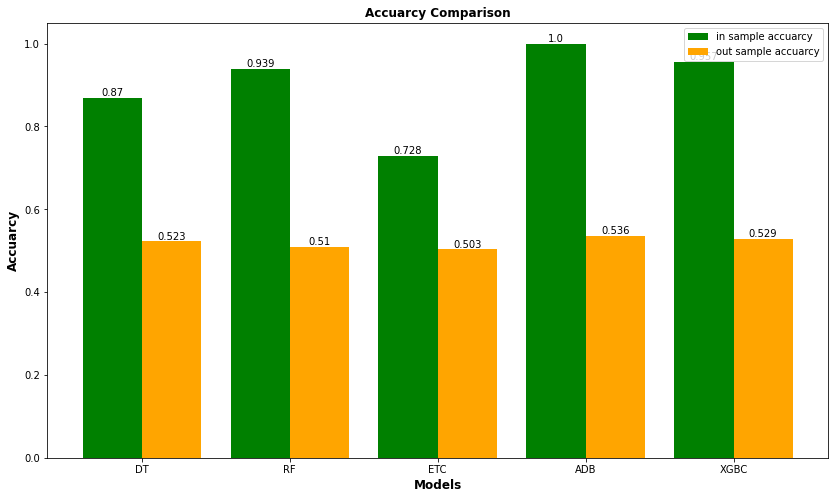

In [52]:
plt.figure(figsize = (14,8))

accuracy_df =pd.DataFrame({'name':names,'accuracy_is':is_accuracy,'accuracy_os':os_accuracy}).set_index('name')
x_axis = np.arange(len(accuracy_df))

barplot_is_accuarcy = plt.bar(x_axis-0.2, accuracy_df['accuracy_is'], 0.4, label='in sample accuarcy',color='green')
barplot_os_accuarcy = plt.bar(x_axis+0.2, accuracy_df['accuracy_os'], 0.4, label='out sample accuarcy',color='orange')

plt.bar_label(barplot_is_accuarcy, labels = np.round(accuracy_df['accuracy_is'],3))
plt.bar_label(barplot_os_accuarcy, labels = np.round(accuracy_df['accuracy_os'],3))

plt.xticks(x_axis, accuracy_df.index)
plt.xlabel("Models", fontsize = 12, fontweight = "bold") 
plt.ylabel("Accuarcy",fontsize = 12, fontweight = "bold")
plt.title("Accuarcy Comparison", fontsize = 12, fontweight = "bold")
plt.legend()
plt.show()

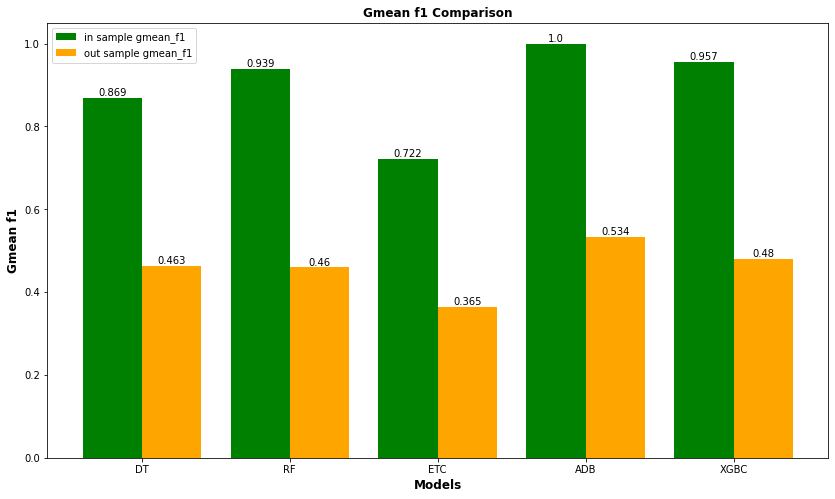

In [53]:
plt.figure(figsize = (14,8))

f1_df =pd.DataFrame({'name':names,'f1_is':is_gmeanf1,'f1_os':os_gmeanf1}).set_index('name')
x_axis = np.arange(len(f1_df))

barplot_is_f1 = plt.bar(x_axis-0.2, f1_df['f1_is'], 0.4, label='in sample gmean_f1',color='green')
barplot_os_f1 = plt.bar(x_axis+0.2, f1_df['f1_os'], 0.4, label='out sample gmean_f1',color='orange')

plt.bar_label(barplot_is_f1, labels = np.round(f1_df['f1_is'],3))
plt.bar_label(barplot_os_f1, labels = np.round(f1_df['f1_os'],3))

plt.xticks(x_axis, f1_df.index)
plt.xlabel("Models", fontsize = 12, fontweight = "bold") 
plt.ylabel("Gmean f1",fontsize = 12, fontweight = "bold")
plt.title("Gmean f1 Comparison", fontsize = 12, fontweight = "bold")
plt.legend()
plt.show()

### Select  Random Forest model

In [90]:
RF= RandomForestClassifier(n_estimators=50,  max_features="log2", max_depth=6,
                           min_samples_leaf=1, min_samples_split=2).fit(X_train,Y_train)

In [91]:
y_pred_RF_is = RF.predict(X_train)
y_pred_RF_os = RF.predict(X_test)
accuracy_RF_is = metrics.accuracy_score(Y_train, y_pred_RF_is)
accuracy_RF_os = metrics.accuracy_score(Y_test.dropna(), y_pred_RF_os[:-1])
print("RF accuarcy in sample:",accuracy_RF_is)
print("RF accuarcy out sample:",accuracy_RF_os)

RF accuarcy in sample: 0.8743882544861338
RF accuarcy out sample: 0.6064516129032258


In [92]:
g_mean_f1_RF_is = g_mean_f1(Y_train, y_pred_RF_is)
g_mean_f1_RF_os = g_mean_f1(Y_test.dropna(), y_pred_RF_os[:-1])
print("RF gmean f1 in sample:",g_mean_f1_RF_is)
print("RF gmean f1 out sample:",g_mean_f1_RF_os)

RF gmean f1 in sample: 0.8740202856871566
RF gmean f1 out sample: 0.5538260235957547


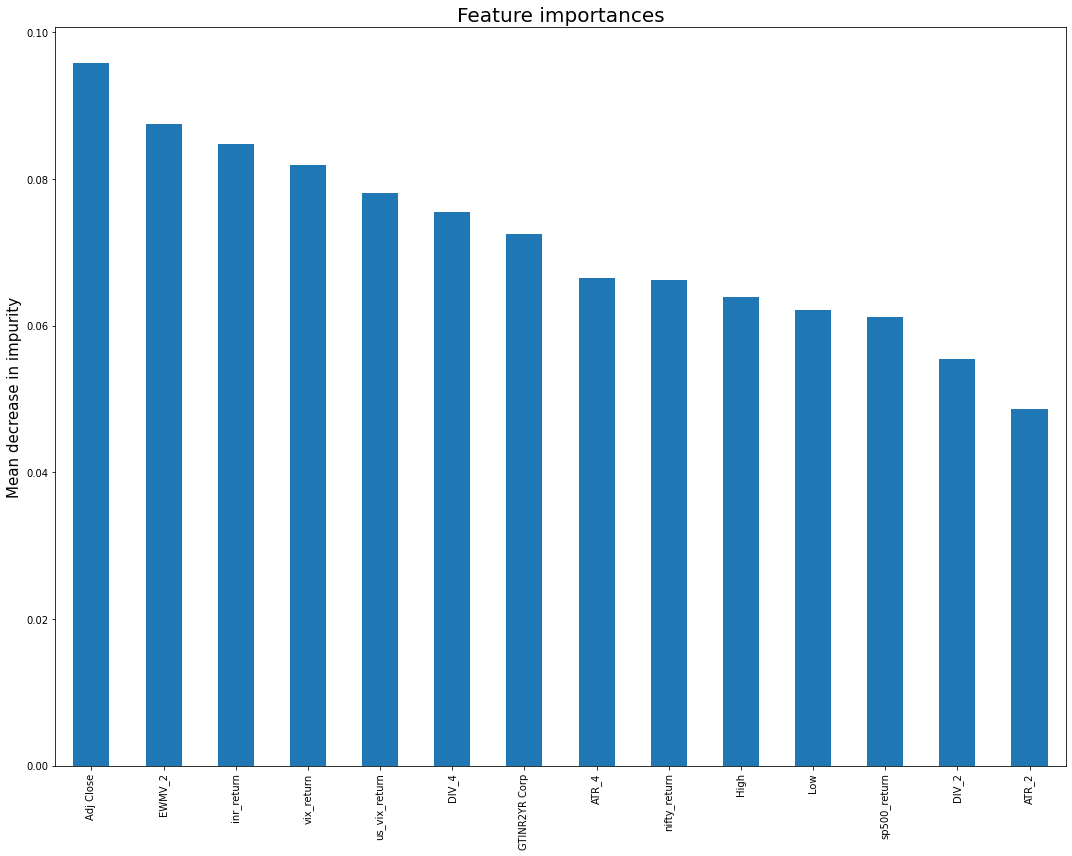

In [93]:
forest_importances = pd.Series(RF.feature_importances_,index=X_train.columns)
forest_importances.sort_values(ascending=False,inplace=True)

fig,ax=plt.subplots(figsize=(15,12))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances",fontsize=20) 
ax.set_ylabel("Mean decrease in impurity",fontsize=15)
fig.tight_layout()

In [94]:
result = pd.DataFrame({'actual':Y_test,'pred':RF.predict(X_test)})
result

,actual,pred
2019-12-06,-1.0,1.0
2019-12-13,-1.0,1.0
2019-12-20,-1.0,1.0
2019-12-27,1.0,1.0
2020-01-03,1.0,1.0
...,...,...
2022-10-28,-1.0,1.0
2022-11-04,-1.0,-1.0
2022-11-11,-1.0,-1.0
2022-11-18,-1.0,1.0


In [95]:
result.to_csv('india_result.csv')

In [97]:
### class 1
len(result[result.actual == 1])/ len(result)

0.4230769230769231

In [98]:
### class 0
len(result[result.actual == -1])/ len(result)

0.5705128205128205